#                             Hate Speech Recognition

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import string

In [2]:
# Load data
df = pd.read_csv('labeled_data.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [4]:
display(df)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
# Assuming your DataFrame is named df
numeric_columns = ['count', 'hate_speech', 'offensive_language', 'neither']

# Display summary statistics for numeric columns
numeric_summary = df[numeric_columns].describe()

# Display the range for each numeric column
column_ranges = pd.DataFrame({
    'Column': numeric_columns,
    'Range': df[numeric_columns].max() - df[numeric_columns].min()
})

print("Summary Statistics:")
print(numeric_summary)
print("\nColumn Ranges:")
print(column_ranges)

Summary Statistics:
              count   hate_speech  offensive_language       neither
count  24783.000000  24783.000000        24783.000000  24783.000000
mean       3.243473      0.280515            2.413711      0.549247
std        0.883060      0.631851            1.399459      1.113299
min        3.000000      0.000000            0.000000      0.000000
25%        3.000000      0.000000            2.000000      0.000000
50%        3.000000      0.000000            3.000000      0.000000
75%        3.000000      0.000000            3.000000      0.000000
max        9.000000      7.000000            9.000000      9.000000

Column Ranges:
                                Column  Range
count                            count      6
hate_speech                hate_speech      7
offensive_language  offensive_language      9
neither                        neither      9


In [6]:
df.isnull().any()

Unnamed: 0            False
count                 False
hate_speech           False
offensive_language    False
neither               False
class                 False
tweet                 False
dtype: bool

In [7]:
# Target variable
y = df['class']

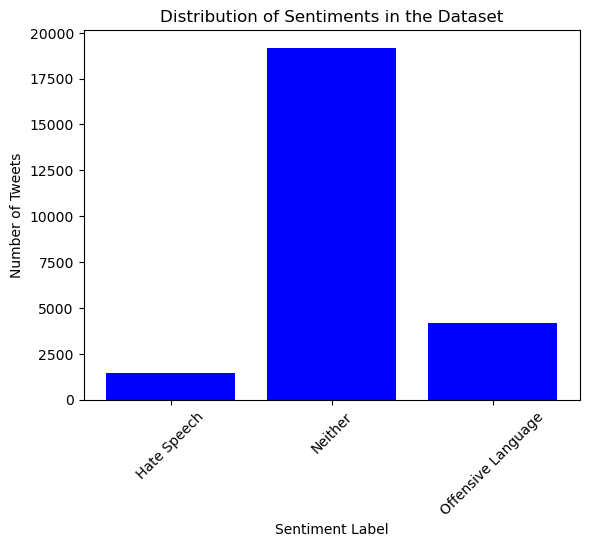

In [8]:
import matplotlib.pyplot as plt

# Assuming 'class' is the column containing the class labels (0, 1, 2)
sentiment_distribution = df['class'].value_counts()


order = [2, 1, 0]  
# Plotting the bar chart
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='blue')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiments in the Dataset')
plt.xticks(sentiment_distribution.index, ['Neither', 'Offensive Language', 'Hate Speech'], rotation=45)
plt.show()

In [9]:
def clean_and_preprocess(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('rt', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [10]:
def vectorize_text(corpus, vectorizer):
    X = vectorizer.fit_transform(corpus)
    print(f"{vectorizer.__class__.__name__} Matrix:")
    print(X.toarray())
    return X

In [11]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")

    classification_rep = classification_report(y_test, y_pred)
    print("\nClassification Report:\n", classification_rep)

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Plotting the Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Neither', 'Offensive Language', 'Hate Speech'],
            yticklabels=['Neither', 'Offensive Language', 'Hate Speech'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [12]:
# Clean and preprocess text
df['processed_tweet'] = df['tweet'].apply(clean_and_preprocess)

In [13]:
# Vectorization
corpus = df['processed_tweet'].tolist()

In [14]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,processed_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman shouldnt complain cleaning ...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe place
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg ever fuck bitch sta cry con...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,cganderson vivabased look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikarobes shit hear might true might faker ...


Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet', 'processed_tweet'],
      dtype='object')


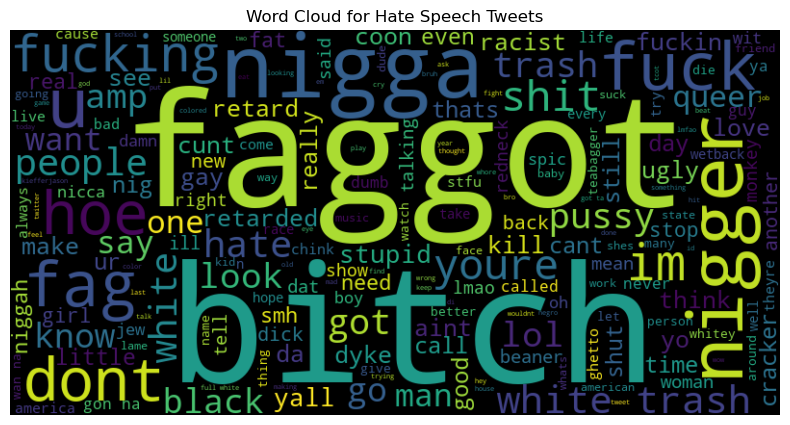

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Print column names to check for the correct column name
print(df.columns)

# Update the column name based on your DataFrame
hate_speech_tweets = ' '.join(df[df['class'] == 0]['processed_tweet'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(hate_speech_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech Tweets')
plt.show()

In [16]:
# Bag-of-Words (BoW) Representation
vectorizer_bow = CountVectorizer(max_features=5000)  # Adjust max_features as needed
X_bow = vectorize_text(corpus, vectorizer_bow)

CountVectorizer Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
# TF-IDF Representation
#Term Frequency-Inverse Document Frequency
vectorizer_tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = vectorize_text(corpus, vectorizer_tfidf)

TfidfVectorizer Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

Model Accuracy: 0.8846076255799878

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.26      0.31       290
           1       0.92      0.95      0.93      3832
           2       0.84      0.82      0.83       835

    accuracy                           0.88      4957
   macro avg       0.71      0.68      0.69      4957
weighted avg       0.87      0.88      0.88      4957

Confusion Matrix:
 [[  76  191   23]
 [  95 3626  111]
 [  26  126  683]]


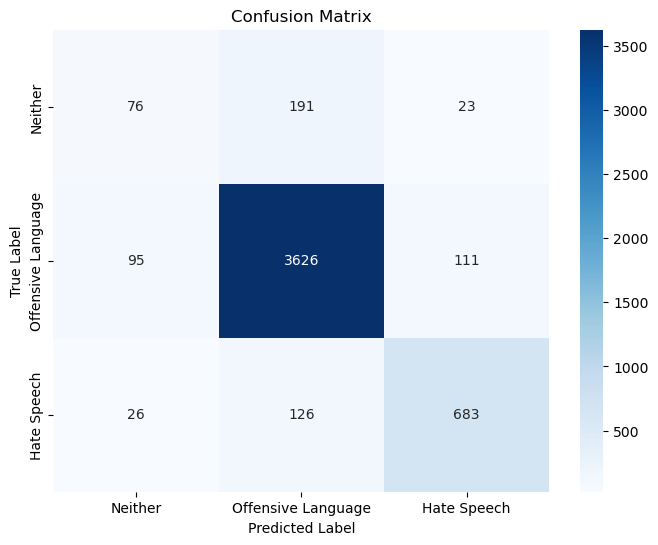

In [19]:
# SVM Model
svm_model = SVC(kernel='linear', random_state=42)
train_and_evaluate_model(svm_model, X_train, y_train, X_test, y_test)

Model Accuracy: 0.8888440589065967

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.29      0.36       290
           1       0.92      0.95      0.93      3832
           2       0.83      0.83      0.83       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.71      4957
weighted avg       0.88      0.89      0.88      4957

Confusion Matrix:
 [[  84  182   24]
 [  83 3632  117]
 [  11  134  690]]


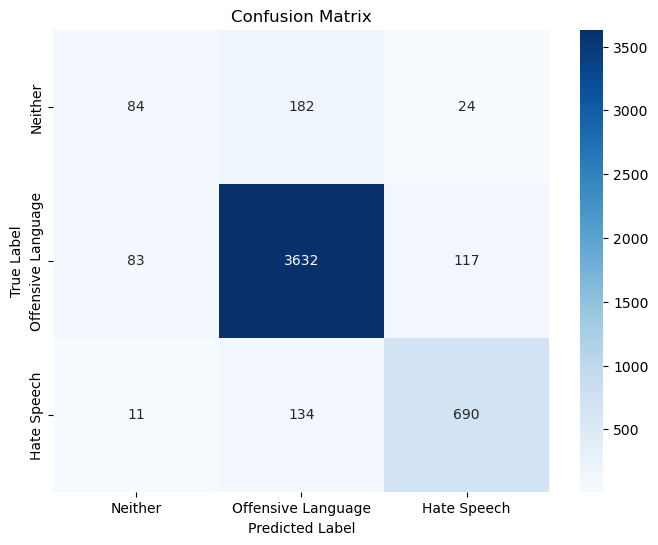

In [20]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)

Model Accuracy: 0.8789590478111761

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.23      0.29       290
           1       0.91      0.96      0.93      3832
           2       0.83      0.75      0.79       835

    accuracy                           0.88      4957
   macro avg       0.72      0.65      0.67      4957
weighted avg       0.87      0.88      0.87      4957

Confusion Matrix:
 [[  67  190   33]
 [  78 3662   92]
 [  20  187  628]]


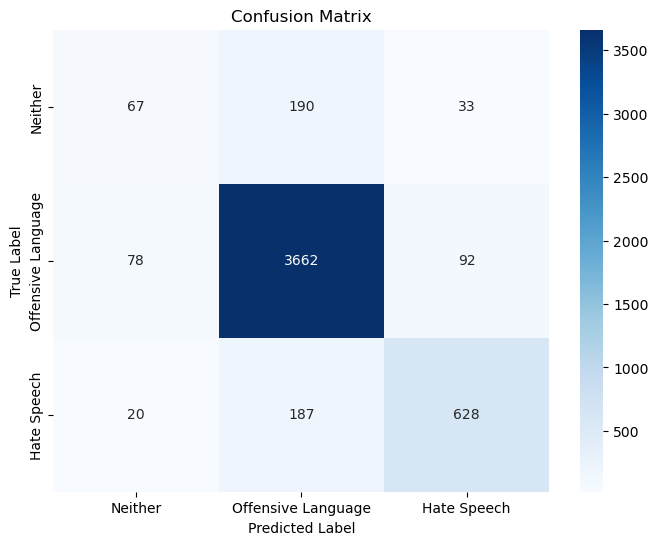

In [21]:
# Naive Bayes Model
nb_model = MultinomialNB()
train_and_evaluate_model(nb_model, X_train, y_train, X_test, y_test)

Model Accuracy: 0.8926770223925762

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.23      0.30       290
           1       0.92      0.95      0.94      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.68      0.69      4957
weighted avg       0.88      0.89      0.88      4957

Confusion Matrix:
 [[  66  195   29]
 [  71 3654  107]
 [  10  120  705]]


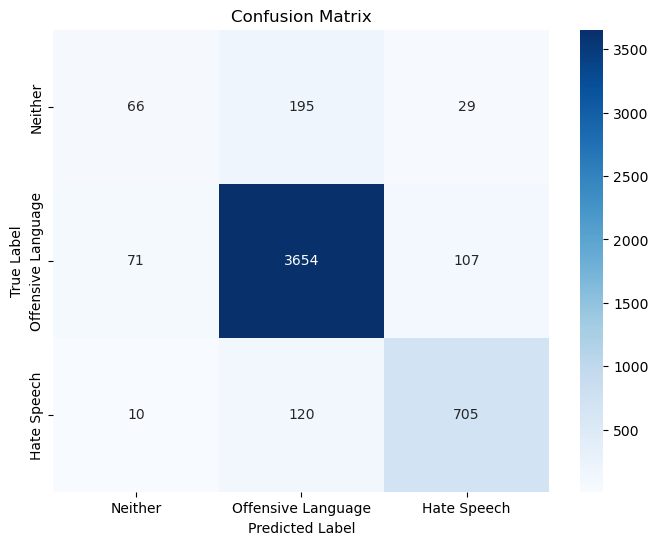

In [22]:
#Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
train_and_evaluate_model(logreg_model, X_train, y_train, X_test, y_test)

Recognizing and classifying the user input

In [23]:
# Save the Random Forest model
model_save_path = '/Users/rav/Codes/AI project/rf_model.pkl'
joblib.dump(rf_model, model_save_path)
print(f"Random Forest model saved to {model_save_path}")

# Save the BoW vectorizer
vectorizer_save_path = '/Users/rav/Codes/AI project/vectorizer_bow.pkl'
joblib.dump(vectorizer_bow, vectorizer_save_path)
print(f"Vectorizer saved to {vectorizer_save_path}")

# Load the Random Forest model and the saved vectorizer
loaded_rf_model = joblib.load(model_save_path)
loaded_vectorizer_bow = joblib.load(vectorizer_save_path)
print("Model and vectorizer loaded successfully.")

# User input
user_input = input("Enter the text to classify: ")

# Preprocess and vectorize the input
cleaned_input = clean_and_preprocess(user_input)
vectorized_input = loaded_vectorizer_bow.transform([cleaned_input])

# Make predictions
prediction = loaded_rf_model.predict(vectorized_input)

# Interpret the result
if prediction == 0:
    result = "Hate Speech"
elif prediction == 1:
    result = "Offensive Language"
else:
    result = "Non-Offensive"

print(f"The input text is classified as: {result}")

Random Forest model saved to /Users/rav/Codes/AI project/rf_model.pkl
Vectorizer saved to /Users/rav/Codes/AI project/vectorizer_bow.pkl
Model and vectorizer loaded successfully.
Enter the text to classify: Jews should be killed
The input text is classified as: Hate Speech


In [24]:
# Save the Logistic Regression model
logreg_model_save_path = '/Users/rav/Codes/AI project/logreg_model.pkl'
joblib.dump(logreg_model, logreg_model_save_path)
print(f"Logistic Regression model saved to {logreg_model_save_path}")

# Save the BoW vectorizer (assuming vectorizer_bow is already loaded)
vectorizer_save_path = '/Users/rav/Codes/AI project/vectorizer_bow.pkl'
joblib.dump(vectorizer_bow, vectorizer_save_path)
print(f"Vectorizer saved to {vectorizer_save_path}")

# Load the Logistic Regression model and the saved vectorizer
loaded_logreg_model = joblib.load(logreg_model_save_path)
loaded_vectorizer_bow = joblib.load(vectorizer_save_path)
print("Model and vectorizer loaded successfully.")

# User input
user_input = input("Enter the text to classify: ")

# Preprocess and vectorize the input
cleaned_input = clean_and_preprocess(user_input)
vectorized_input = loaded_vectorizer_bow.transform([cleaned_input])

# Make predictions
prediction = loaded_logreg_model.predict(vectorized_input)

# Interpret the result
if prediction == 0:
    result = "Hate Speech"
elif prediction == 1:
    result = "Offensive Language"
else:
    result = "Non-Offensive"

print(f"The input text is classified as: {result}")


Logistic Regression model saved to /Users/rav/Codes/AI project/logreg_model.pkl
Vectorizer saved to /Users/rav/Codes/AI project/vectorizer_bow.pkl
Model and vectorizer loaded successfully.
Enter the text to classify: India is a great nation
The input text is classified as: Non-Offensive


Model Accuracy: 0.8452693161186201

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.32      0.35       290
           1       0.88      0.94      0.91      3832
           2       0.77      0.61      0.68       835

    accuracy                           0.85      4957
   macro avg       0.68      0.62      0.65      4957
weighted avg       0.84      0.85      0.84      4957

Confusion Matrix:
 [[  92  169   29]
 [ 125 3587  120]
 [  20  304  511]]


/Users/rav/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


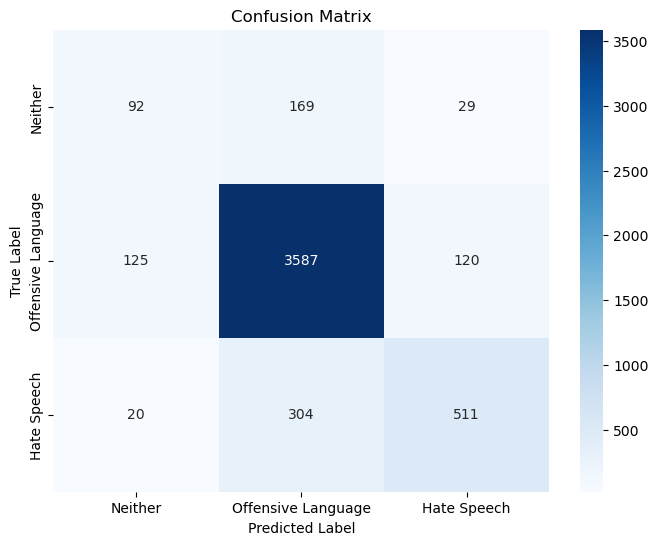

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Example:
knn_model = KNeighborsClassifier()
train_and_evaluate_model(knn_model, X_train, y_train, X_test, y_test)